# Multiclass classification prediction for popularity of a song

Import all the packages

In [65]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, softmax

%matplotlib widget
import matplotlib.pyplot as plt

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

## Import data

In [66]:
df = pd.read_csv("spotify_data/spotify_songs.csv")

df = df.drop(['track_id','track_name','track_album_id','track_album_name','playlist_id','playlist_name'], axis= 1 ) # These features are not needed for prediction
df.head()

,track_artist,track_popularity,track_album_release_date,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,Ed Sheeran,66,2019-06-14,pop,dance pop,0.748,0.916,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,Maroon 5,67,2019-12-13,pop,dance pop,0.726,0.815,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,Zara Larsson,70,2019-07-05,pop,dance pop,0.675,0.931,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,The Chainsmokers,60,2019-07-19,pop,dance pop,0.718,0.930,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,Lewis Capaldi,69,2019-03-05,pop,dance pop,0.650,0.833,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


In [67]:
df.shape

(32833, 17)

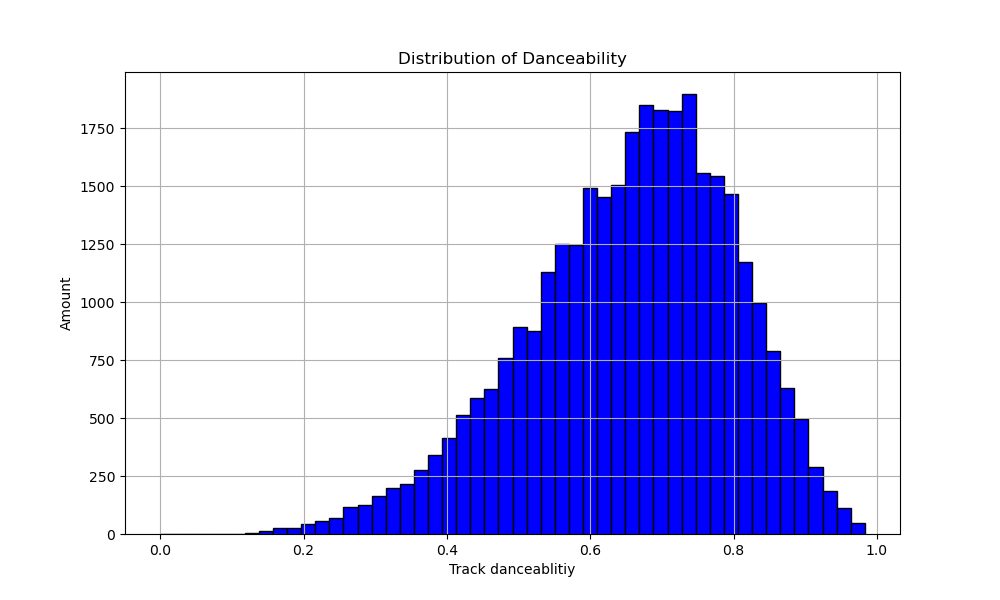

In [68]:
# Plot the distribution of track_popularity
plt.figure(figsize=(10,6))
plt.hist(df['danceability'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Danceability')
plt.xlabel('Track danceablitiy')
plt.ylabel('Amount')
plt.grid(True)
plt.show()

### Checking for null or NaN values

In [69]:
missing_danceability = df['danceability'].isnull().any()

missing_danceability

False

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_artist              32828 non-null  object 
 1   track_popularity          32833 non-null  int64  
 2   track_album_release_date  32833 non-null  object 
 3   playlist_genre            32833 non-null  object 
 4   playlist_subgenre         32833 non-null  object 
 5   danceability              32833 non-null  float64
 6   energy                    32833 non-null  float64
 7   key                       32833 non-null  int64  
 8   loudness                  32833 non-null  float64
 9   mode                      32833 non-null  int64  
 10  speechiness               32833 non-null  float64
 11  acousticness              32833 non-null  float64
 12  instrumentalness          32833 non-null  float64
 13  liveness                  32833 non-null  float64
 14  valenc

## Divide track_popularity in classes(labels)

In [71]:
# Define the bin edges and labels
bin_edges = [0, 0.6, 0.8, 1]
bin_labels = [0, 1, 2] # ['Trash', 'Flop', 'Average', 'Hit', 'Monsterhit']

# Create a new column 'popularity_label' based on the bins
df['danceability'] = pd.cut(df['danceability'], bins=bin_edges, labels=bin_labels, include_lowest=True)
df['track_danceability_label'] = df['danceability']

In [72]:
df = df.drop(['danceability'],axis=1)

## Change release date to release year + scale duration to seconds

make df['release_year'] a new column that stores the first 4 characters of df['track_album_release_date'] which is of Object type df['release_year'] = df['track_album_release_date'].astype(str).str[0:4].astype(int)

In [73]:
# Release date to years
df['track_album_release_date'] = pd.to_datetime(df['track_album_release_date'], errors='coerce')
df['release_year'] = (df['track_album_release_date'].dt.year)

df = df.drop(['track_album_release_date'], axis=1)

In [74]:
# Drop rows with missing values
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32828 entries, 0 to 32832
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   track_artist              32828 non-null  object  
 1   track_popularity          32828 non-null  int64   
 2   playlist_genre            32828 non-null  object  
 3   playlist_subgenre         32828 non-null  object  
 4   energy                    32828 non-null  float64 
 5   key                       32828 non-null  int64   
 6   loudness                  32828 non-null  float64 
 7   mode                      32828 non-null  int64   
 8   speechiness               32828 non-null  float64 
 9   acousticness              32828 non-null  float64 
 10  instrumentalness          32828 non-null  float64 
 11  liveness                  32828 non-null  float64 
 12  valence                   32828 non-null  float64 
 13  tempo                     32828 non-null  floa

In [75]:
# Track duration from ms to s
df['duration_ms'] = df['duration_ms']/1000

In [76]:
df = df.rename(columns={'duration_ms': 'duration_s'})

In [77]:
df.head()

,track_artist,track_popularity,playlist_genre,playlist_subgenre,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_s,track_danceability_label,release_year
0,Ed Sheeran,66,pop,dance pop,0.916,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194.754,1,2019
1,Maroon 5,67,pop,dance pop,0.815,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162.600,1,2019
2,Zara Larsson,70,pop,dance pop,0.931,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176.616,1,2019
3,The Chainsmokers,60,pop,dance pop,0.930,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169.093,1,2019
4,Lewis Capaldi,69,pop,dance pop,0.833,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189.052,1,2019


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32828 entries, 0 to 32832
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   track_artist              32828 non-null  object  
 1   track_popularity          32828 non-null  int64   
 2   playlist_genre            32828 non-null  object  
 3   playlist_subgenre         32828 non-null  object  
 4   energy                    32828 non-null  float64 
 5   key                       32828 non-null  int64   
 6   loudness                  32828 non-null  float64 
 7   mode                      32828 non-null  int64   
 8   speechiness               32828 non-null  float64 
 9   acousticness              32828 non-null  float64 
 10  instrumentalness          32828 non-null  float64 
 11  liveness                  32828 non-null  float64 
 12  valence                   32828 non-null  float64 
 13  tempo                     32828 non-null  floa

## Making the model

### Dataset

In [79]:
X, y = df.drop(['track_danceability_label', 'track_artist', 'playlist_genre', 'playlist_subgenre'],axis=1).to_numpy(), df['track_danceability_label'].to_numpy()

In [80]:
print ('The shape of X is: ' + str(X.shape))
print ('The shape of y is: ' + str(y.shape))

The shape of X is: (32828, 13)
The shape of y is: (32828,)


In [81]:
# UNQ_C2
# GRADED CELL: Sequential model
tf.random.set_seed(1234) # for consistent results
model = Sequential(
    [
        ### START CODE HERE ###

        tf.keras.Input(shape=(13,)),    #specify input shape
        Dense(100, activation=relu, name="L1", kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        Dense(20, activation=relu, name="L2", kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        Dense(3, activation=linear, name="L3"),
        
        ### END CODE HERE ###
    ], name = "my_model"
)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [82]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 100)               1400      
                                                                 
 L2 (Dense)                  (None, 20)                2020      
                                                                 
 L3 (Dense)                  (None, 3)                 63        
                                                                 
Total params: 3483 (13.61 KB)
Trainable params: 3483 (13.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [83]:
[layer1, layer2, layer3] = model.layers

In [84]:
#### Examine Weights shapes
W1,b1 = layer1.get_weights()
W2,b2 = layer2.get_weights()
W3,b3 = layer3.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

W1 shape = (13, 100), b1 shape = (100,)
W2 shape = (100, 20), b2 shape = (20,)
W3 shape = (20, 3), b3 shape = (3,)


In [94]:
history = model.fit(
    X,y,
    epochs=40
)

Epoch 1/40
1026/1026 [==============================] - 2s 2ms/step - loss: 2.0401 - accuracy: 0.4452
Epoch 2/40
1026/1026 [==============================] - 2s 2ms/step - loss: 1.9525 - accuracy: 0.4419
Epoch 3/40
1026/1026 [==============================] - 2s 2ms/step - loss: 1.9952 - accuracy: 0.4491
Epoch 4/40
1026/1026 [==============================] - 2s 2ms/step - loss: 1.7637 - accuracy: 0.4488
Epoch 5/40
1026/1026 [==============================] - 2s 2ms/step - loss: 1.6774 - accuracy: 0.4534
Epoch 6/40
1026/1026 [==============================] - 2s 2ms/step - loss: 1.6333 - accuracy: 0.4528
Epoch 7/40
1026/1026 [==============================] - 2s 2ms/step - loss: 1.5761 - accuracy: 0.4589
Epoch 8/40
1026/1026 [==============================] - 2s 2ms/step - loss: 1.5523 - accuracy: 0.4552
Epoch 9/40
1026/1026 [==============================] - 2s 2ms/step - loss: 1.4915 - accuracy: 0.4629
Epoch 10/40
1026/1026 [==============================] - 2s 2ms/step - loss: 1.415

In [95]:
def plot_loss_tf(history):
    fig,ax = plt.subplots(1,1, figsize = (5,5))
    ax.plot(history.history['loss'], label='loss')
    ax.set_ylim([0, 10])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('loss (cost)')
    ax.legend()
    ax.grid(True)
    plt.show()

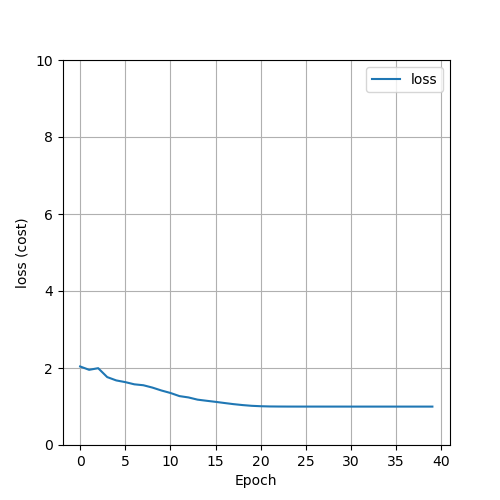

In [96]:
plot_loss_tf(history)

In [97]:
df.head()
#give df value at row 23
df.iloc[2]
#give me the row with the highest track_popularity_label         
df.loc[df['track_danceability_label'].idxmax()]

track_artist                Ed Sheeran
track_popularity                    66
playlist_genre                     pop
playlist_subgenre            dance pop
energy                           0.835
key                                  0
loudness                        -4.603
mode                                 1
speechiness                     0.0896
acousticness                      0.13
instrumentalness              0.000005
liveness                         0.365
valence                          0.722
tempo                          125.028
duration_s                      188.23
track_danceability_label             2
release_year                      2019
Name: 15, dtype: object

In [98]:
Ed_IHE_Remix = X[41]
print(Ed_IHE_Remix.shape)
prediction = model.predict(Ed_IHE_Remix.reshape(1,13))
print(f" predicting a Two: \n{prediction}")  # Moet toch zijn: predicting a Four?
print(f" Largest Prediction index: {np.argmax(prediction)}")

(13,)
1/1 [==============================] - 0s 30ms/step
 predicting a Two: 
[[ 0.01230356  0.46372265 -0.72513586]]
 Largest Prediction index: 1


In [99]:
prediction_p = tf.nn.softmax(prediction)

print(f" predicting a Two. Probability vector: \n{prediction_p}") # Moet toch zijn: predicting a Four?
yhat = np.argmax(prediction_p)

print(f"np.argmax(prediction_p): {yhat}")

 predicting a Two. Probability vector: 
[[0.32798964 0.5151206  0.15688963]]
np.argmax(prediction_p): 1


1/1 [==============================] - 0s 21ms/step


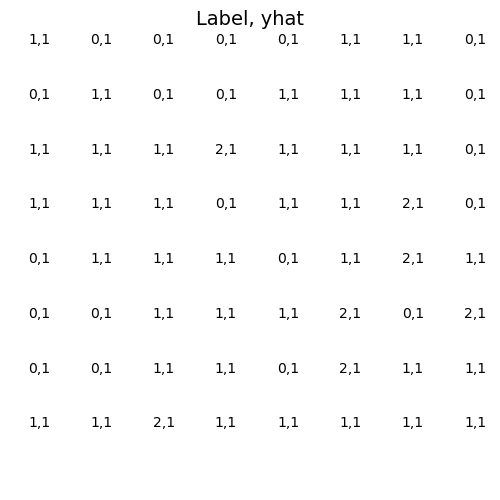

In [100]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# You do not need to modify anything in this cell

m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(5,5))
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]

for i,ax in enumerate(axes.flat):
    random_index = np.random.randint(m)

    # Predict using the Neural Network
    prediction = model.predict(X[random_index].reshape(1,13))
    prediction_p = tf.nn.softmax(prediction)
    yhat = np.argmax(prediction_p)
    
    # Display the label above the image
    ax.set_title(f"{y[random_index]},{yhat}",fontsize=10)
    ax.set_axis_off()
    
fig.suptitle("Label, yhat", fontsize=14)
plt.show()

In [92]:
def display_errors(model,X,y):
    f = model.predict(X)
    yhat = np.argmax(f, axis=1)
    doo = yhat != y[:]
    idxs = np.where(yhat != y[:])[0]
    if len(idxs) == 0:
        print("no errors found")
    else:
        cnt = min(8, len(idxs))
        fig, ax = plt.subplots(1,cnt, figsize=(5,2))
        fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.80]) #[left, bottom, right, top]

        for i in range(cnt):
            j = idxs[i]
            
            # Predict using the Neural Network
            prediction = model.predict(X[j].reshape(1,13))
            prediction_p = tf.nn.softmax(prediction)
            yhat = np.argmax(prediction_p)

            # Display the label above the image
            ax[i].set_title(f"{y[j]},{yhat}",fontsize=10)
            ax[i].set_axis_off()
            fig.suptitle("Label, yhat", fontsize=12)
    return(len(idxs))

1/1 [==============================] - 0s 20ms/step
22028 errors out of 32828 images


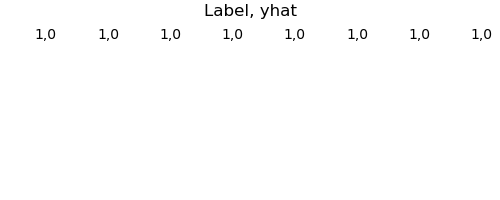

In [93]:
print( f"{display_errors(model,X,y)} errors out of {len(X)} images")